 # Лекционная часть

In [2]:
import torch
from torch import nn
import numpy as np
from matplotlib import pyplot as plt

## Pooling

Pooling это по сути еще виды свертки, average pooling - свертка матрицей из значений 1/количество элементов в ядре (в результате свертки получаем среднее значение окна) и еще с несколькими модификациями (об этом ниже), для max pooling - свертка возвращает максимальное значение окна

Пулинги используются для:

- Уменьшения размерности признаков
- Приведения признаков к одному размеру в нейронных сетях со сверточными слоями, так как в зависимости от размеров фото размеры признаков будут также разными (для этого используется AdaptivePooling, который проходится по матрице с таким окном, чтобы выходной размер был тем, что определен заранее) 

### Задача: визуализировать пулинг фото при помощи AvgPool2d, MaxPool2d

*Обратите внимание на порядок измерений в фото и в тензоре, подающемуся в слой PyTorch,*

*([height, width, num_channels] и [batch_size, num_channels, height, width] соответственно)*

*а также на тип данных тензора*

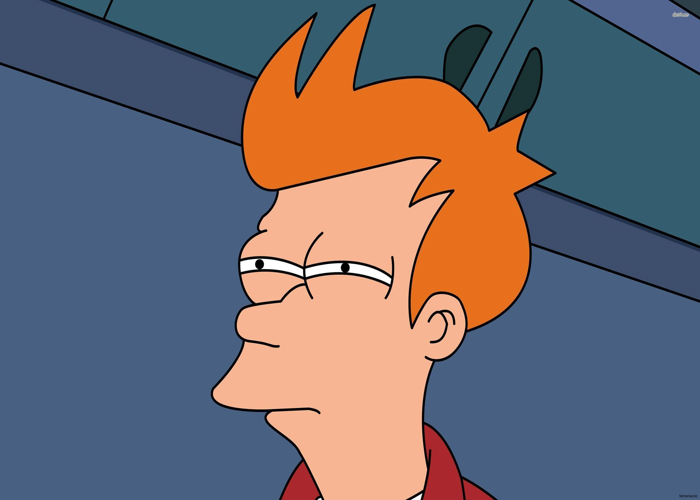

In [10]:
from PIL import Image
import requests
from io import BytesIO

image_url = 'https://i.pinimg.com/originals/5d/c1/5a/5dc15a58073122dfbb1db83934e49fdc.jpg'

response = requests.get(image_url)
img = Image.open(BytesIO(response.content))
img = img.resize((700, 500))
img

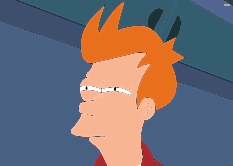

In [13]:
from torchvision import transforms

def pool_image(img: Image.Image, pooling_layer: torch.nn.Module) -> Image.Image:
    img_tensor = transforms.PILToTensor()(img)
    img_tensor = img_tensor.float()
    max_pooled_im = pooling_layer(img_tensor[None])[0]
    return transforms.ToPILImage()(max_pooled_im.to(torch.uint8))

kernel_size = 3

max_pool = torch.nn.MaxPool2d(kernel_size)
pool_image(img, max_pool)


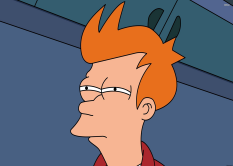

In [118]:
avg_pool = torch.nn.AvgPool2d(kernel_size)
pool_image(img, avg_pool)

### Задача: сравните результат работы AvgPool2d и Conv2d с ядром, которое будет совершать аналогичную операцию

*Чтобы Conv2d выводил тот же результат, кроме кастомного ядра нужно будет поставить параметр groups=3, и изменить параметр stride*

groups - группировка каналов, по умолчанию равен 1 - тогда при свертке агрегируются значения со всех каналов, если значение будет равно количеству каналов - агрегация будет сделана на каждом канале независимо от других



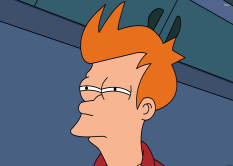

In [119]:
conv_pool = torch.nn.Conv2d(3, 3, kernel_size, groups=3, stride=3)

avg_kernel = torch.full((3, 1, kernel_size, kernel_size), 1 / kernel_size ** 2)
conv_pool.weight = torch.nn.Parameter(avg_kernel)
pool_image(img, conv_pool)

In [116]:
avg_pooled_array = np.array(pool_image(img, avg_pool))
conv_pooled_array = np.array(pool_image(img, conv_pool))
same_values_rate = (avg_pooled_array == conv_pooled_array).mean()
print(f'Доля одинаковых пикселей в двух вариантах пулинга: {same_values_rate:.2%}')

Доля одинаковых пикселей в двух вариантах пулинга: 96.45%


### Задача: используйте AdapriveAvgPooling2d для приведения фото к размеру 200 на 200, визуализируйте

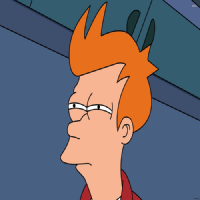

In [120]:
avg_pool = torch.nn.AdaptiveAvgPool2d((200, 200))
pool_image(img, avg_pool)

## Развитие архитектур сверточных сетей

За основу взята статья: https://habr.com/ru/post/511372/

### LeNet-5 (1998 год)

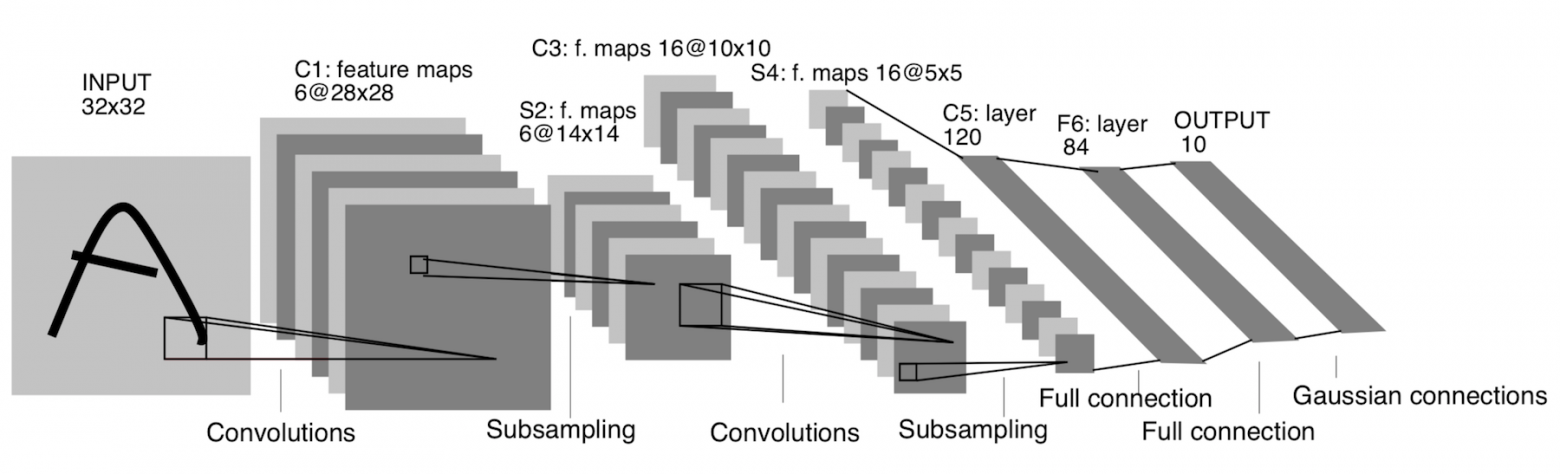

Появилась аж в 1998 году! Была предназначена для распознавания рукописных букв и цифр. Под subsampling (понижение размерности) здесь подразумевается pooling-слой.

Сейчас эта архитектура имеет только историческую значимость. Подобную архитектуру легко имплементировать «ручками» в любом современном фреймворке для глубокого обучения.

Архитектура:

CONV 5x5, stride = 1

POOL 2x2, stride = 2

CONV 5x5, stride = 1

POOL 5x5, stride = 2

FC (120, 84)

FC (84, 10)

### Популяризация

Хорошим толчком и показателем развития архитектур/приемов CNN является The ImageNet Large Scale Visual Recognition Challenge (ILSVRC) - на большом датасете ImageNet ресерчеры сравнивают качество и эффективность на задаче классификации. 

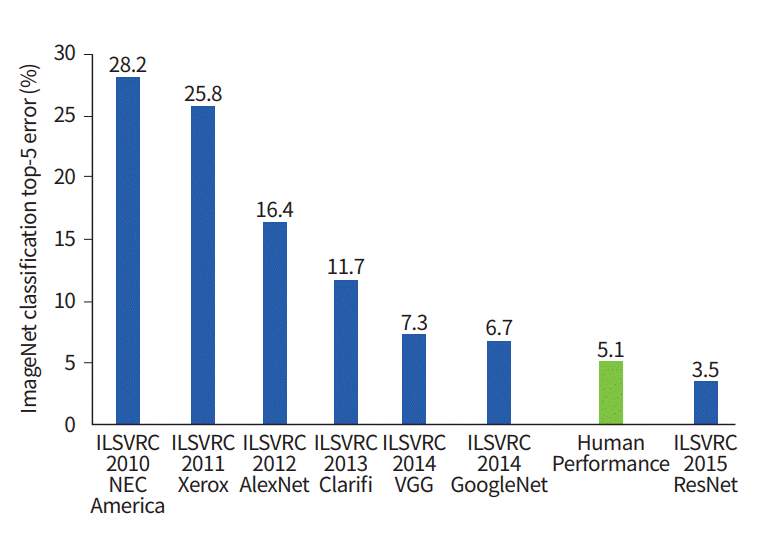

По оси x — года и алгоритмы (с 2012 года — сверточные нейронные сети).

По оси y — процент ошибок на выборке из top-5 error.

Top-5 error — это способ оценивания модели: модель возвращает некое распределение вероятностей и если среди топ-5 вероятностей есть истинное значение (метка класса) класса, то ответ модели считается правильным. Соответственно, (1 — top-1 error) — это всем знакомая точность (accuracy).

### AlexNet (2012 год)

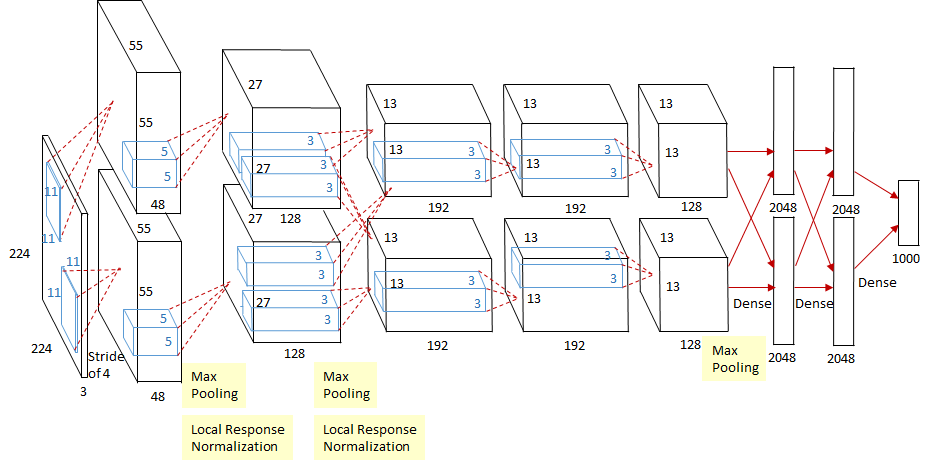

Картинка не дублируется. Так изображена архитектура, потому что архитектура AlexNet тогда не влезала на одно устройство GPU, поэтому «половина» сети работала на одной GPU, а вторая — на другой.

Появилась в 2012 году. С нее и начался прорыв в том самом ILSVRC — она победила все state-of-the-art модели того времени. После этого люди поняли, что нейронные сети действительно работают :)

Архитектура более конкретно:

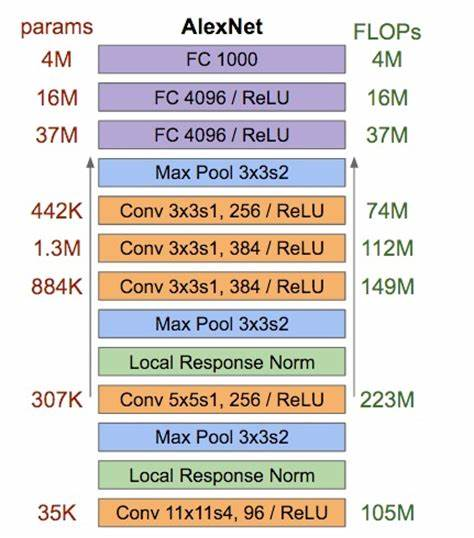

Если приглядеться на архитектуру AlexNet, то можно увидеть, что за 14 лет (с появления LeNet-5) не произошло почти никаких изменений, кроме кол-ва слоев.

Важно:

- Мы берем нашу исходную картинку 227x227x3 и понижаем ее размерность (по высоте и ширине), но увеличиваем кол-во каналов. Такая часть архитектуры «кодирует» изначальное представление объекта (encoder).
- Впервые была применена функция активации ReLU.
- 60 миллионов обучаемых параметров.
- Основная часть обучаемых параметров приходится на полносвязные слои.

Примечания:

- Local Response Norm — это способ нормализации, который использовался в сетях того времени. Сейчас используют batch-normalization.
- Запись вида FC 4096 означает, что полносвязный (Fully-connected) слой имеет 4096 выходных нейронов.
- Запись вида Max Pool 3x3s2 означает, что слой пулинга имеет фильтр 3x3, шаг = 2.
- 96 в записи Conv 11x11s4, 96 означает выходное количество каналов у слоя

### VGGNet (2014 год)

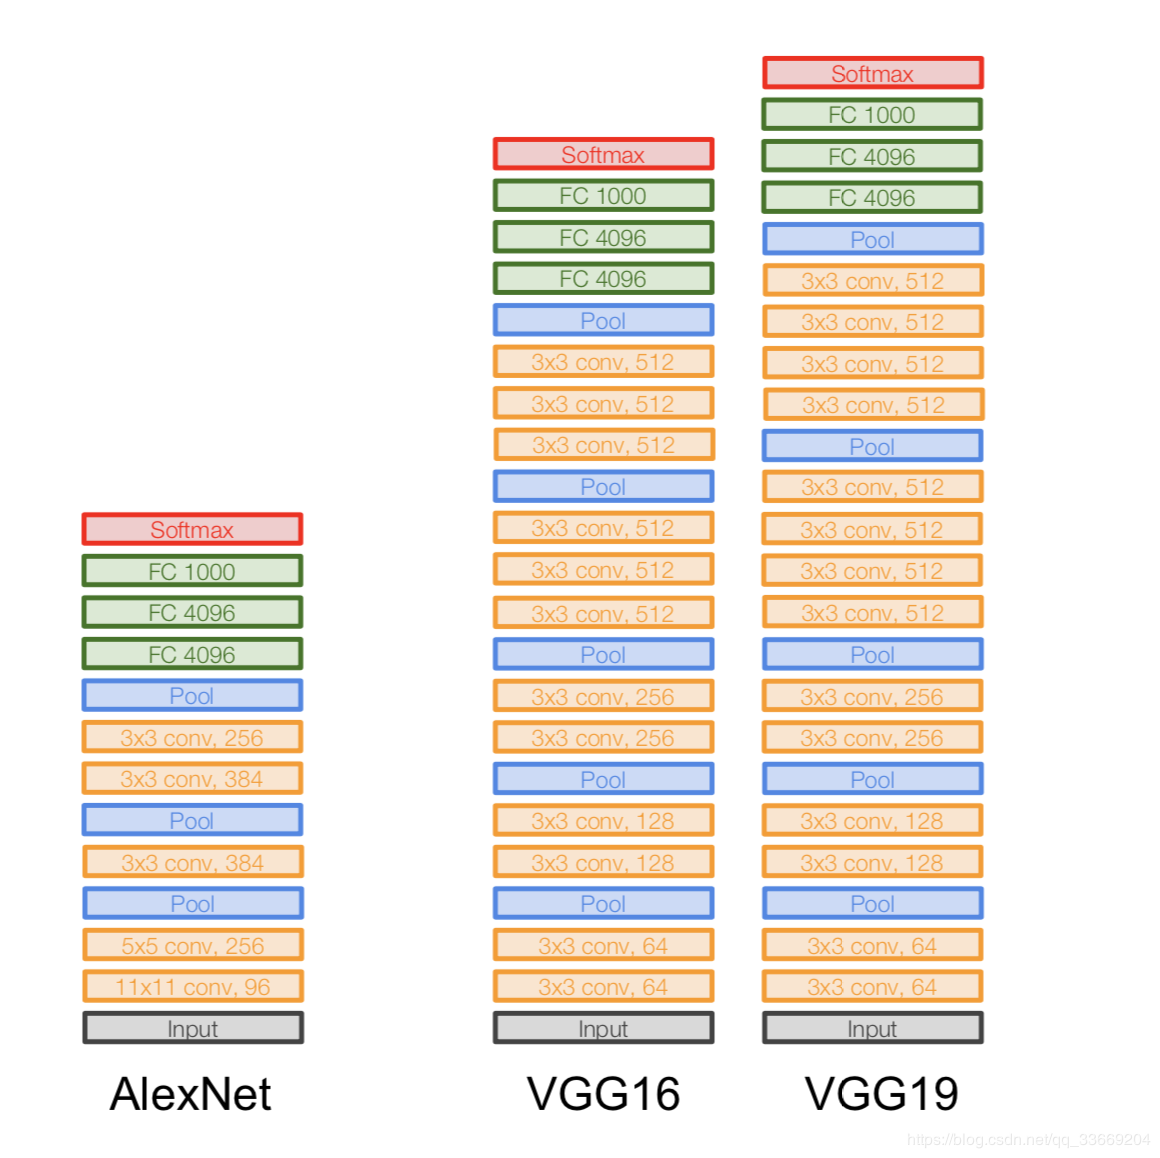

Две версии — VGG16 и VGG19. Основная идея — использовать вместо больших сверток (11x11 и 5x5) маленькие свертки (3x3). Интуиция в использовании больших сверток простая — мы хотим получать больше информации от соседних пикселей, но гораздо лучше использовать маленькие фильтры чаще.

И вот почему:

- Каждый последующий слой свертки обладает информацией о предыдущем. И чем сильнее мы углубляемся, тем больше информации последний сверточный слой содержит о первом (receptive field). Т.е. мы добились того, чего хотели добиться большими свертками, но в малом количестве.
- Мы слабее уменьшаем размерность нашего изображения => можем применять больше сверток.
Больше сверток — больше активаций, больше активаций — больше нелинейности, а нелинейность — это как раз то, чего мы добиваемся.

Сеть имеет 138 миллионов обучаемых параметров в вариации 16-ти слоев и 143 миллиона параметров в вариации 19-ти слоев.

Примерная реализация VGG16

In [8]:
class VGG16(nn.Module):
    
    def __init__(
            self, 
            num_classes: int = 1000, 
            dropout: float = 0.5,
            ):
        
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
model = VGG16()
num_parameters = sum(p.numel() for p in model.parameters())
print(f'Количество параметров: {num_parameters:_}')


Количество параметров: 138_357_544


Удобный способ использовать подобные архитектуры (в том числе с предобученными весами) - timm

In [5]:
import timm

timm.list_models('vgg*')

['vgg11',
 'vgg11_bn',
 'vgg13',
 'vgg13_bn',
 'vgg16',
 'vgg16_bn',
 'vgg19',
 'vgg19_bn']

In [6]:
model = timm.create_model('vgg16')
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Можно указать pretrained=True для загрузки модели с готовыми весами, num_classes для указания, сколько классов должна выдавать модель, in_chans в случае, если фото в вашем датасете не 3-канальные, features_only=True если вы хотите просто извлечь признаки

https://timm.fast.ai/create_model

In [ ]:
# Пример
# timm.create_model('vgg11', pretrained=True, in_chans=1)

### GoogleNet (2014 год)

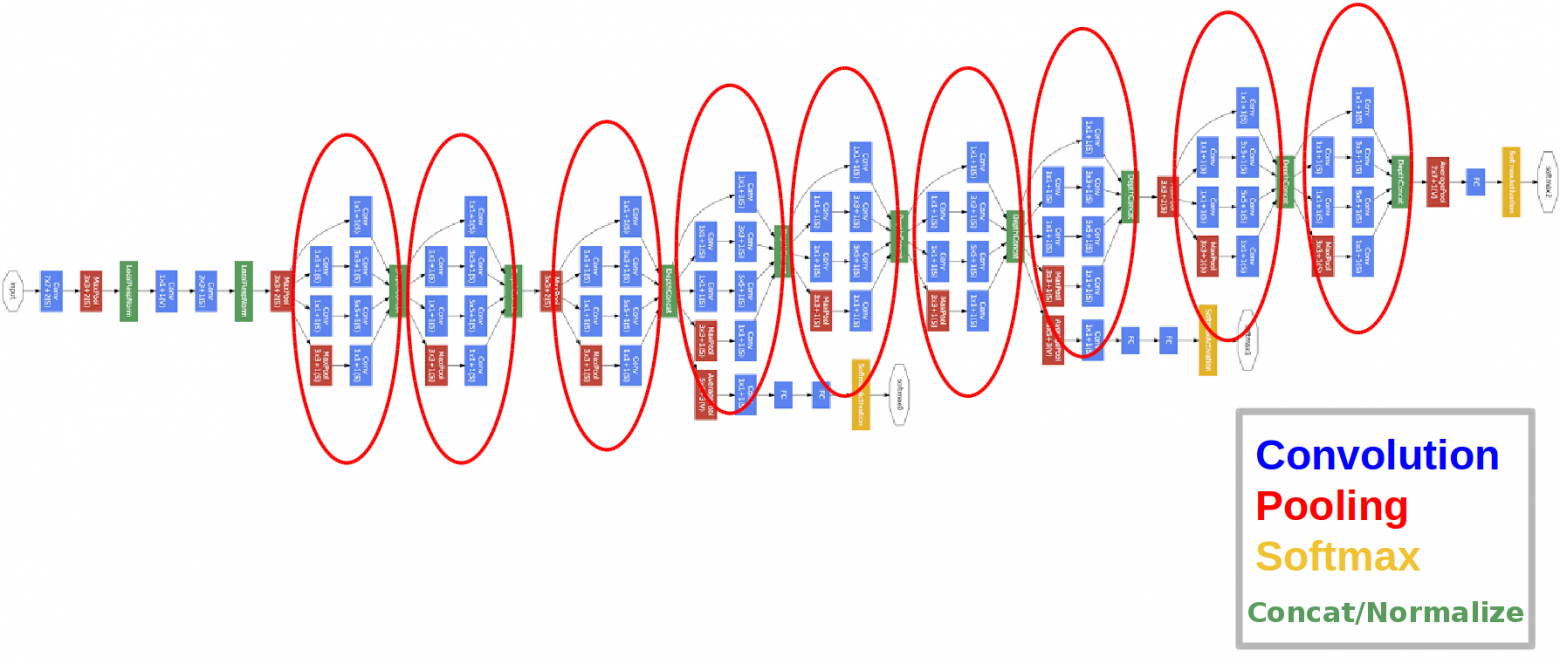

Красные кружочки — это так называемый Inception module.

Давайте взглянем на него поближе:

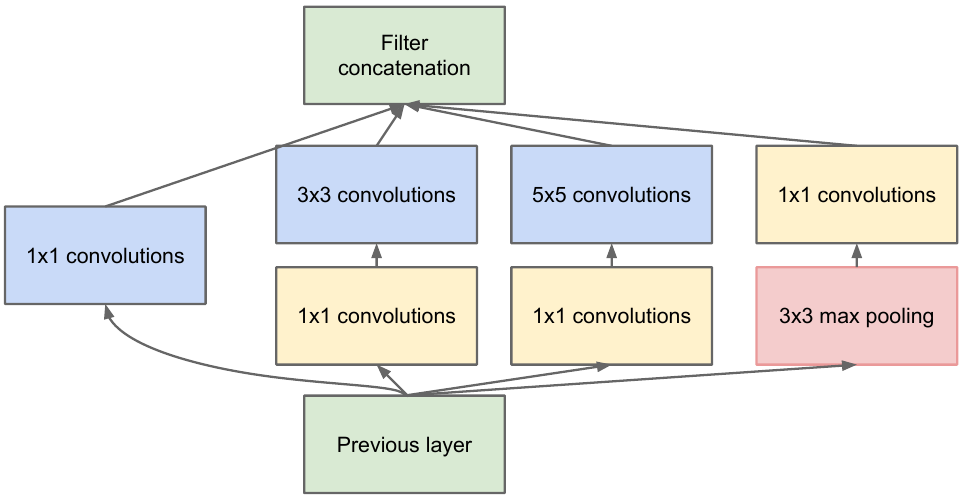

Мы берем карту признаков (feature map) с предыдущего слоя, применяем к ней какое-то количество сверток с разными фильтрами, потом конкатенируем полученное. Интуиция простая: мы хотим получить различные представления нашей карты признаков, используя фильтры разных размеров. Свертки 1x1 используются для того, чтобы не так сильно наращивать кол-во каналов после каждого такого inception-блока. Т.е. когда у карты признаков большое кол-во каналов, и хотят уменьшить это кол-во, не изменяя высоту и ширину карты признаков, используют свертку размерности 1x1.

Также в сети присутствуют три блока-классификатора, вот так выглядит один из них (тот что справа для нас):

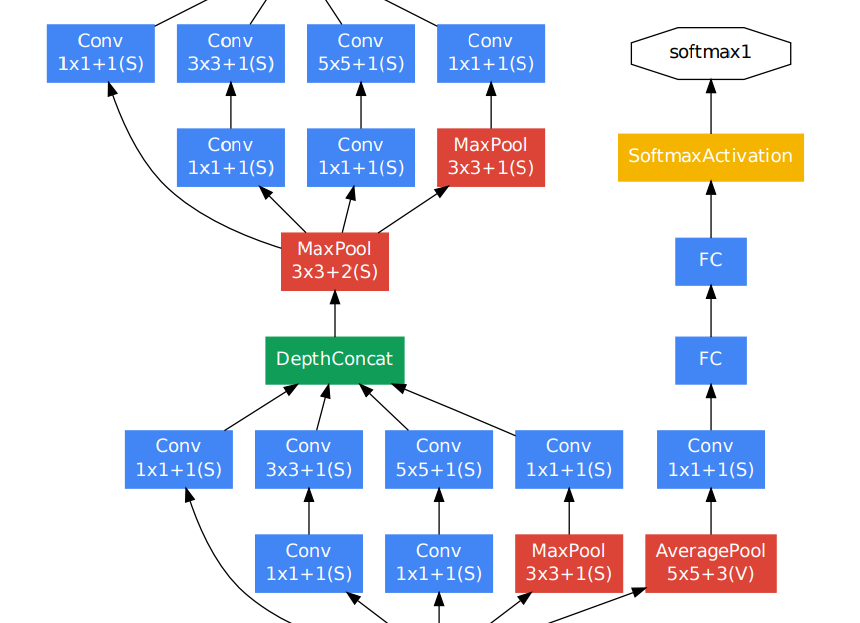

С помощью такой конструкции градиент «лучше» доходит от выходных слоев до входных во время обратного распространения ошибки.

Зачем нужны еще два лишних выхода сети? Дело все в так называемой проблеме затухающего градиента (vanishing gradient problem):

Суть в том, что при выполнении обратного распространения ошибки градиент банально стремится к нулю. Чем глубже сеть — тем она более подвержена этому явлению. Почему так происходит? Когда мы выполняем backward pass, мы идем от выхода ко входу, вычисляя градиенты сложных функций. Производная сложной функции (chain rule) — это, по сути, умножение. И вот так, умножая какие-то значения по пути от выхода ко входу, мы встречаем числа, которые близки к нулю, и, как следствие, веса нейронной сети практически не обновляются. 

Частично это проблема функций активаций типа sigmoid, у которых выход лежит в каком-то фиксированном диапазоне. Ну и частично эта проблема решается путем использования функции активации ReLu. Почему частично? Потому что никто не дает гарантии на значения обучаемых параметров и представления входного объекта во всех картах признаков.

Важно:

- Сеть имеет 22 слоя (это чуть больше, чем имеет предыдущая сеть).
- Число обучаемых параметров равно пяти миллионам, что в разы и разы меньше, чем у предыдущих двух сетей.
- Появление сверток 1x1.
- Используются Inception блоки.
- Вместо полносвязных слоев теперь свертки 1x1, которые понижают глубину и, как следствие, понижают размерность полносвязных слоев и слой global average pooling.
- Архитектура имеет 3 выхода (итоговый ответ взвешивается).

### ResNet (2015 год)

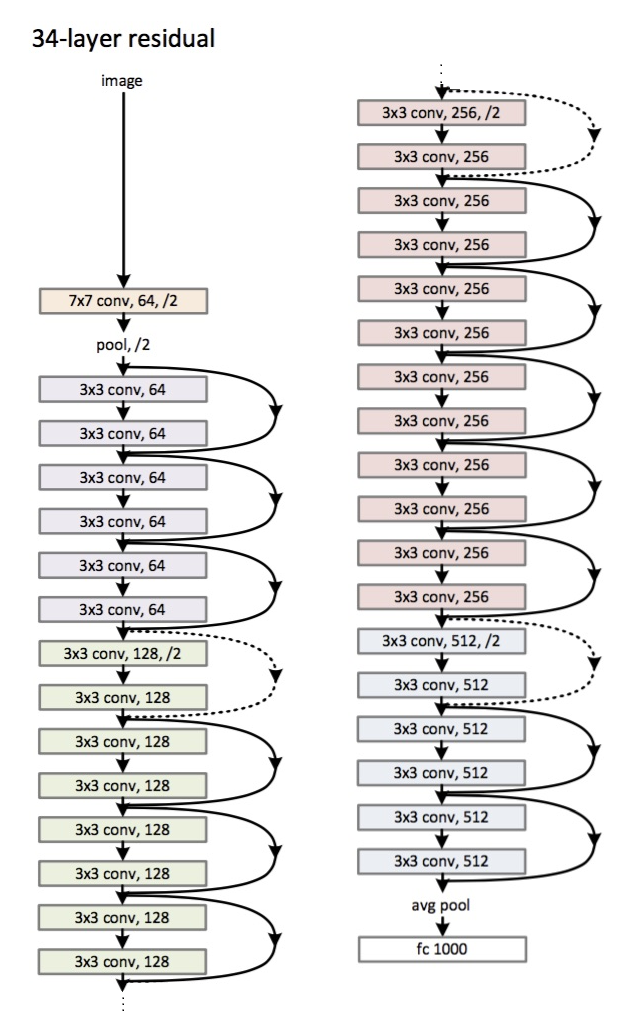

Основным новшеством стало большое количество слоев и, так называемые, residual блоки. Эти блоки используются в качестве борьбы с проблемой затухающего градиента. Связь между такими residual-блоками называется shortcut (стрелочки на картинке). Теперь по этим шорткатам градиент и будет доходить до всех нужных параметров, тем самым обучая сеть :)   

Важно:

- Вместо полносвязных слоев — average global pooling (для каждого выходного канала берется среднее).
- Residual-блоки.
- Сеть превзошла человека в распознавании образов на датасете ImageNet (top-5 error).
- Впервые использован batch-normalization.
- Используется техника инициализации весов (интуиция: из определенной инициализации весов сеть сходится (обучается) быстрее и лучше).
- Максимальная глубина — 152 слоя!

Реализация residual блока очень проста:

In [ ]:
class ResidualBlock(torch.nn.Module):
    def __init__(self, module):
        self.module = module

    def forward(self, inputs):
        return self.module(inputs) + inputs

Дальнейшее развитие нейронок в области computer vision - to be continued

### Задача: нарисовать heatmapы карт признаков, создаваемых при помощи предобученной resnet

*Модель, созданная в timm с параметром features_only=True будет возвращать список карт признаков на разной глубине*

*Для визуализации все каналы признаков нужно будет усреднить*

In [11]:
timm.list_models('resnet*')

['resnet10t',
 'resnet14t',
 'resnet18',
 'resnet18d',
 'resnet26',
 'resnet26d',
 'resnet26t',
 'resnet32ts',
 'resnet33ts',
 'resnet34',
 'resnet34d',
 'resnet50',
 'resnet50_gn',
 'resnet50d',
 'resnet50t',
 'resnet51q',
 'resnet61q',
 'resnet101',
 'resnet101d',
 'resnet152',
 'resnet152d',
 'resnet200',
 'resnet200d',
 'resnetaa50',
 'resnetaa50d',
 'resnetaa101d',
 'resnetblur18',
 'resnetblur50',
 'resnetblur50d',
 'resnetblur101d',
 'resnetrs50',
 'resnetrs101',
 'resnetrs152',
 'resnetrs200',
 'resnetrs270',
 'resnetrs350',
 'resnetrs420',
 'resnetv2_50',
 'resnetv2_50d',
 'resnetv2_50d_evob',
 'resnetv2_50d_evos',
 'resnetv2_50d_frn',
 'resnetv2_50d_gn',
 'resnetv2_50t',
 'resnetv2_50x1_bit_distilled',
 'resnetv2_50x1_bitm',
 'resnetv2_50x1_bitm_in21k',
 'resnetv2_50x3_bitm',
 'resnetv2_50x3_bitm_in21k',
 'resnetv2_101',
 'resnetv2_101d',
 'resnetv2_101x1_bitm',
 'resnetv2_101x1_bitm_in21k',
 'resnetv2_101x3_bitm',
 'resnetv2_101x3_bitm_in21k',
 'resnetv2_152',
 'resnetv2_152

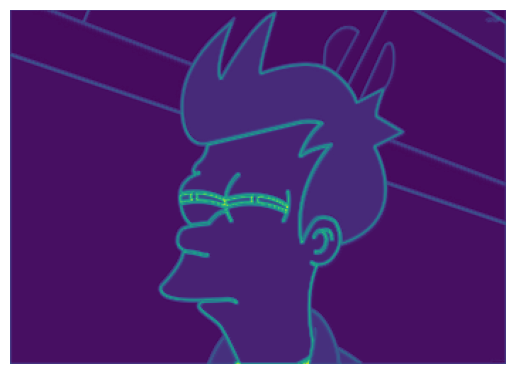

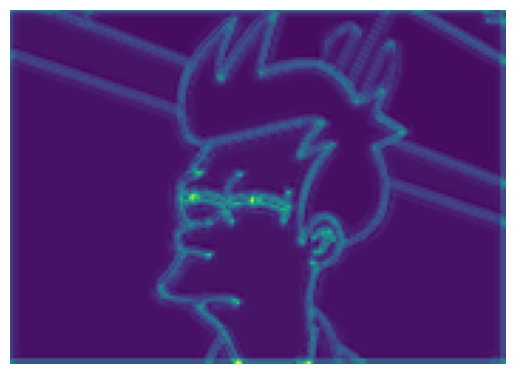

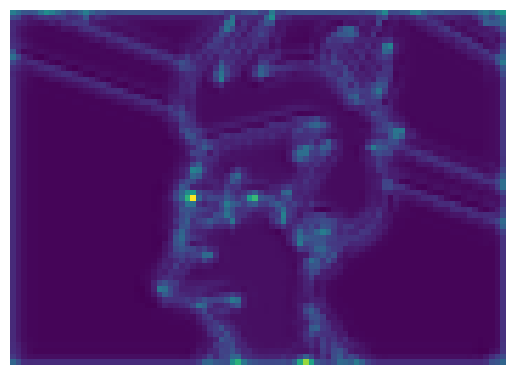

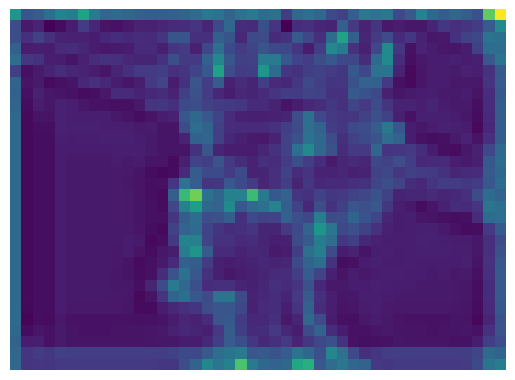

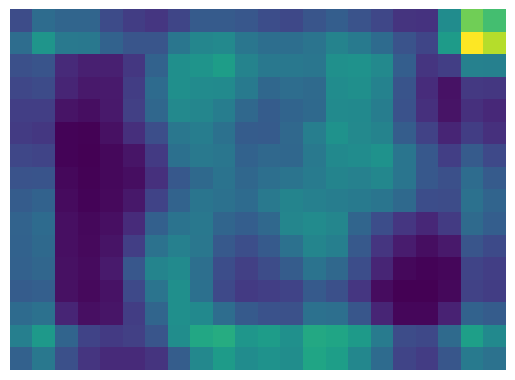

In [26]:
model = timm.create_model('resnet18', pretrained=True, features_only=True)
img_tensor = transforms.PILToTensor()(img).float()
featuremaps = model(img_tensor[None])

for featuremap in featuremaps:
    plt.imshow(featuremap[0].mean(0).detach())
    plt.axis('off')
    plt.show()

## Pytorch Lighnting

Обертка над PyTorch, главная цель - автоматизация шаблонного кода, позволяющая концентрироваться на важных вещах

https://lightning.ai/docs/pytorch/stable/starter/introduction.html

Продемонстрируем его работу

### Модель

In [49]:
import lightning.pytorch as pl

# define the LightningModule
class CustomCNN(pl.LightningModule):
    def __init__(
            self, 
            num_classes: int, 
            criterion: nn.Module=torch.nn.CrossEntropyLoss()
            ):
        super().__init__()
        # Тело нейронки, выдает логиты
        self.inner = nn.Sequential(
            nn.Conv2d(1, 3, 3),
            nn.ReLU(),
            nn.Conv2d(3, 5, 3),
            nn.ReLU(),
            nn.Conv2d(5, 10, 3),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(4840, num_classes),
        )
        self.criterion = criterion
        
    def forward(self, x):
        return self.inner(x)

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        x, y = batch
        x = x.to(self.device)
        y = y.to(self.device)
        
        logits = self.forward(x)

        loss = self.criterion(logits, y)        
        # Logging to TensorBoard (if installed) by default
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
    
    def test_step(self, batch, batch_idx):
        # this is the test loop
        logits = self(batch[0])
        target = batch[1]
        pred = logits.argmax(dim=1)
        acc = (pred == target).float().mean().item()
        self.log('test_acc', acc)

### Dataset

In [31]:
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

data_path = './data/fmnist'
# данные в виде картинок 28x28
# ToTensor превратит в тензоры 1x28x28
train_dataset = datasets.FashionMNIST(data_path, train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.FashionMNIST(data_path, train=False, download=True, transform=transforms.ToTensor())
num_classes = len(datasets.FashionMNIST.classes)
train_loader = DataLoader(train_dataset, num_workers=8)

### Train

In [46]:
model = CustomCNN(num_classes=num_classes)
trainer = pl.Trainer(limit_train_batches=100, max_epochs=10)
trainer.fit(model=model, train_dataloaders=train_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /Users/user/Main/Teach/БАЙТ/byte-deep-learning/3_conv/lightning_logs

  | Name      | Type             | Params
-----------------------------------------------
0 | inner     | Sequential       | 49.0 K
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
49.0 K    Trainable params
0         Non-trainable params
49.0 K    Total params
0.196     Total estimated model params size (MB)
/Users/user/Main/Teach/БАЙТ/byte-deep-learning/venv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performa

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


### Test

In [50]:
# load checkpoint
checkpoint = "./lightning_logs/version_0/checkpoints/epoch=9-step=1000.ckpt"
model = CustomCNN.load_from_checkpoint(checkpoint, num_classes=num_classes)
trainer.test(model, dataloaders=DataLoader(test_dataset, num_workers=8))

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6815999746322632     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.6815999746322632}]

## Inductive bias